In [91]:
import os
import time
from watermark import watermark

import numpy as np
import shutil

from nltk.tokenize import wordpunct_tokenize
from sklearn.linear_model import LogisticRegression

from src.preprocessors import OneHotCustomVectorizer
from src.data_utils import load_data
from src.tabular_utils import training_tabular
from src.misc import dump_config

from pprint import pprint

from lightning.lite.utilities.seed import seed_everything

import shap

SEED = 33
VOCAB_SIZE = 1024
MAX_LEN = 128
LIMIT = 1000

# ===========================================
print(f"[!] Script start time: {time.ctime()}")
TOKENIZER = wordpunct_tokenize

# LOADING DATA
ROOT = "./"
X_train_cmds, y_train, X_test_cmds, y_test, X_train_malicious_cmd, X_train_baseline_cmd, X_test_malicious_cmd, X_test_baseline_cmd = load_data(ROOT, SEED, limit=LIMIT)


# PREPROCESSING
# tokenizer = CommandTokenizer(tokenizer_fn=TOKENIZER, vocab_size=VOCAB_SIZE, max_len=MAX_LEN)
oh = OneHotCustomVectorizer(tokenizer=TOKENIZER, max_features=VOCAB_SIZE)
print("[*] Fitting One-Hot encoder...")
X_train_onehot = oh.fit_transform(X_train_cmds)
X_test_onehot = oh.transform(X_test_cmds)

log_reg_onehot = LogisticRegression(random_state=SEED)

log_reg_trained = training_tabular(
    model=log_reg_onehot,
    name="log_reg_onehot",
    X_train_encoded=X_train_onehot,
    X_test_encoded=X_test_onehot,
    y_train=y_train,
    y_test=y_test,
    logs_folder="./temp",
    model_file=None
)
shutil.rmtree('./temp')

[!] Script start time: Wed Jan 31 14:44:19 2024
[*] Fitting One-Hot encoder...
[*] Training log_reg_onehot model...
[!] log_reg_onehot model scores: train_tpr=1.0000, train_f1=0.9990, train_acc=0.9990, train_auc=1.0000
[!] log_reg_onehot model scores: val_tpr=1.0000, val_f1=1.0000, val_acc=1.0000, val_auc=1.0000


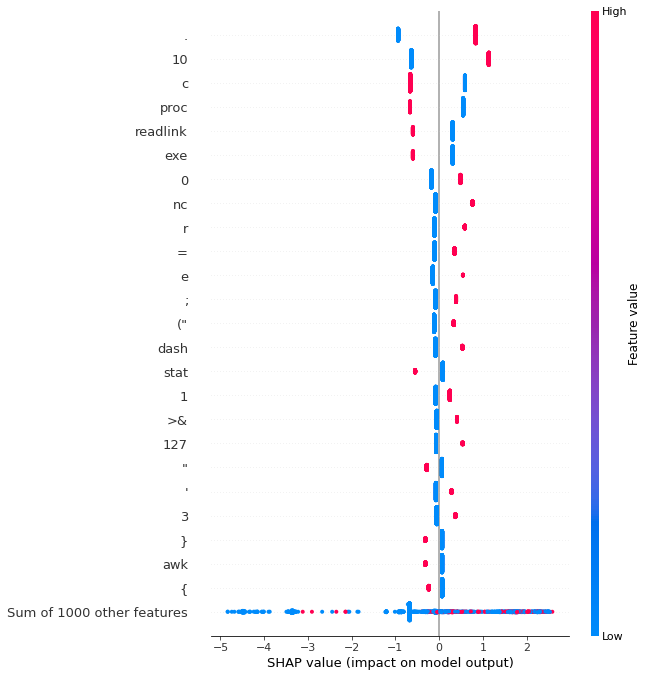

In [100]:
explainer = shap.LinearExplainer(
    log_reg_trained,
    X_train_onehot,
    feature_names=list(oh.vocab.keys())
)
shap_values = explainer(X_test_onehot)
shap.plots.beeswarm(shap_values, max_display=25)

In [96]:
# get weights of log reg model
log_reg_weights = log_reg_trained.coef_
vocab = oh.vocab

# find top 10 most important features
TOP_HEAVIEST = 15
top_10_idx_malicious = np.argsort(log_reg_weights[0])[-TOP_HEAVIEST:][::-1]
top_10_features_malicious = [list(vocab.keys())[idx] for idx in top_10_idx_malicious]
print(top_10_features_malicious)

['.', '10', 'nc', 'r', 'e', '0', 'dash', '127', 'cu', 'eu', ';', '<&', '>&', 'rcat', '=']


In [99]:
TOP_LIGHT = 15
top_10_idx_benign = np.argsort(log_reg_weights[0])[:TOP_LIGHT]
top_10_features_benign = [list(vocab.keys())[idx] for idx in top_10_idx_benign]
print(top_10_features_benign)

['c', 'proc', 'exe', 'readlink', 'stat', 'zk0', 'net', 'cloudapp', 'internal', 'w', '}', 'awk', '"', 'null', '{']
